In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
pd.set_option('display.max_columns', 50)

In [2]:
# Load the dataset
df_final_dataset_copy = pd.read_csv('Data/final_dataset.csv', index_col= 0)
df_final_dataset = df_final_dataset_copy.copy()

# load the data again
df_copy = pd.read_csv("Data/df_filtered.csv", index_col=0)
df = df_copy.copy()



In [3]:
df_final_dataset = df_final_dataset_copy.copy()
df = df_copy.copy()

# run only this cell if you want to reset the dataset


In [ ]:
print( df.columns )
print( df_final_dataset.columns )

# drop the nan values
df = df.dropna(subset = ['userId', 'movieId', 'rating', 'imdbId'])
print( df.head() )
print( df_final_dataset.head() )


In [ ]:
# Diagnostic print to help understand the data
def print_dataframe_info(df):
    print("\nDataFrame Information:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nColumn names:")
    print(df.columns.tolist())

# Uncomment and use these diagnostic functions before creating visualizations
print_dataframe_info(df)
print_dataframe_info(df_final_dataset)

In [ ]:
df_final_dataset = df_final_dataset_copy.copy()
df = df_copy.copy()
import pandas as pd
# import numpy as np
import plotly.express as px
# import plotly.graph_objs as go
# from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
df_final_dataset = df_final_dataset.dropna(subset = ['genres_cmu', 'countries'])

df_final_dataset['genres_cmu'] = df_final_dataset['genres_cmu'].str.split(',').apply(lambda x: [genre.strip() for genre in x]).explode().reset_index(drop=True)
df_final_dataset['countries'] = df_final_dataset['countries'].str.split(',').apply(lambda x: [country.strip() for country in x]).explode().reset_index(drop=True)
df_final_dataset['imdbId'] = df_final_dataset.index.astype(str)
# suppress the first two tokens in the imdbId column 
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].apply(lambda x: x[2:])
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].astype(int)


# Merge the dataframes
df_merged = df.merge(df_final_dataset, on='imdbId', how='left')   
print("DataFrame shapes:")
print("df shape:", df.shape)
print("df_final_dataset shape:", df_final_dataset.shape)

# Merge the dataframes
print("Merged dataframe shape:", df_merged.shape)

# Diagnostic: Check columns and data types
print("\nColumns in merged dataframe:")
print(df_merged.columns)


In [ ]:
df.dropna(subset=['rating'], inplace=True)
print("ratings column:", df_merged['rating'].unique())

# 1. Distribution of Ratings
fig1 = px.histogram(df, x='rating', 
                    title='Distribution of Movie Ratings',
                    labels={'rating': 'Rating', 'count': 'Number of Ratings'},
                    color_discrete_sequence=['#636EFA'])
fig1.show()
fig1.write_html('rating_distribution.html')


In [ ]:

# Calculate mean rating for each user
user_mean_ratings = df.groupby('userId')['rating'].mean().reset_index()

# Create a violin plot for the distribution of mean ratings per user
fig_violin = px.violin(user_mean_ratings, y='rating', 
                       title='Distribution of Mean Ratings per User',
                       labels={'rating': 'Mean Rating'},
                       box=True, points='all')
fig_violin.show()
fig_violin.write_html('mean_rating_violin.html')


In [6]:
df_final_dataset = df_final_dataset_copy.copy()
df = df_copy.copy()
df_final_dataset['imdbId'] = df_final_dataset.index.astype(str)
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].apply(lambda x: x[2:])
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].astype(int)
df['imdbId'] = df['imdbId'].astype(int)  # Ensure same type

# makes index go from 0 to n-1
df_final_dataset = df_final_dataset.reset_index(drop=True)
df_final_dataset = df_final_dataset.dropna(subset=['genres_cmu'])
df_final_dataset['genres_cmu'] = df_final_dataset['genres_cmu'].str.split(',').apply(lambda x: [genre.strip() for genre in x]).explode().reset_index(drop=True)
# Merge the dataframes
df_merged = df.merge(df_final_dataset, on='imdbId', how='left') 
df_merged = df_merged.dropna(subset=['rating', 'genres_cmu'])


In [ ]:
print("columns in merged dataframe:", df_merged.columns)

In [ ]:

# print(df_merged.head())
# 2. Ratings by Genre
try:
    genre_ratings = df_merged.groupby('genres_cmu')['rating'].agg(['mean', 'count']).reset_index()
    genre_ratings = genre_ratings.sort_values('count', ascending=False).head(15)

    fig2 = px.bar(genre_ratings, x='genres_cmu', y='mean', 
                    title='Average Rating by Genre',
                    labels={'mean': 'Average Rating', 'genres_cmu': 'Genre'},
                    color='count', 
                    color_continuous_scale='Viridis')
    fig2.show()
    fig2.write_html('genre_ratings.html')
except Exception as e:
    print("Error in genre ratings visualization:", e)
    fig2 = None


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

user_genre_ratings = df_merged.groupby(['userId', 'genres_cmu'])['rating'].mean().unstack().fillna(0)

# Standardize the data
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_ratings)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
user_pca = pca.fit_transform(user_genre_scaled)

# Visualization of PCA
fig_pca = px.scatter(
    x=user_pca[:, 0], 
    y=user_pca[:, 1], 
    title='PCA Visualization of User Ratings by Genre',
    labels={'x': 'First Principal Component', 'y': 'Second Principal Component'},
    color=user_genre_ratings.index,  # Use index as labels
    color_discrete_sequence=px.colors.qualitative.T10
)
fig_pca.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd

# Step 1: Prepare data for similarity visualization
selected_features = ['userId', 'genres_cmu', 'rating', 'budget']
# Group data by userId and genres_cmu, calculating the mean of ratings and filling NaNs
df_merged.dropna(subset=selected_features, inplace=True)
user_genre_ratings = df_merged.groupby(['userId', 'genres_cmu'])['rating'].mean().unstack().fillna(0)

# Include additional features if available (e.g., budget, etc.)
if 'budget' in df_merged.columns:
    user_genre_ratings['budget'] = df_merged.groupby('userId')['budget'].mean()

subsample_size = 1000  # Adjust to an acceptable size
user_genre_ratings = user_genre_ratings.sample(n=subsample_size, random_state=42)
# Step 2: Standardize the data
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_ratings)

# Step 3: Dimensionality reduction for visualization
# Use PCA for initial dimensionality reduction
pca = PCA(n_components=20)
user_genre_pca = pca.fit_transform(user_genre_scaled)

# Use t-SNE for a more detailed 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
user_genre_tsne = tsne.fit_transform(user_genre_pca)

# Convert the result to a DataFrame for plotting
user_tsne_df = pd.DataFrame(user_genre_tsne, columns=['Component 1', 'Component 2'])
user_tsne_df['userId'] = user_genre_ratings.index

# Step 5: Appliquer KMeans pour créer des clusters
kmeans = KMeans(n_clusters=5, random_state=42)  # Ajustez n_clusters selon vos besoins
user_tsne_df['Cluster'] = kmeans.fit_predict(user_tsne_df[['Component 1', 'Component 2']])

# Step 6: Visualiser les clusters avec des couleurs différentes
fig_similarity = px.scatter(
    user_tsne_df,
    x='Component 1',
    y='Component 2',
    hover_data=['userId'],
    title='User Similarity Visualization Based on Ratings and Genres',
    labels={'Component 1': 't-SNE Component 1', 'Component 2': 't-SNE Component 2'},
    color='Cluster',  # Utiliser la colonne 'Cluster' pour colorier les clusters
    color_continuous_scale='Viridis',  # Vous pouvez changer cette palette si nécessaire
    category_orders={'Cluster': [0, 1]}  # Assurez-vous que les clusters sont ordonnés de manière correcte
)
fig_similarity.show()



c:\Users\Mayeul\anaconda3\envs\ADA\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Optimal Epsilon value: 1.0397999999999956
Eps: 1.0397999999999956


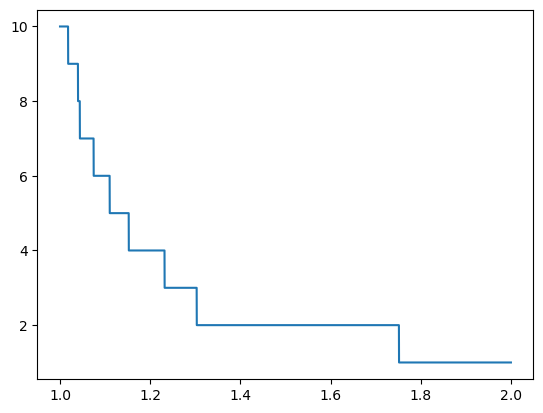

In [7]:
import numpy as np
from sklearn.cluster import DBSCAN
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare data for similarity visualization
selected_features = ['userId', 'genres_cmu', 'rating', 'budget']
# Group data by userId and genres_cmu, calculating the mean of ratings and filling NaNs
df_merged.dropna(subset=selected_features, inplace=True)
user_genre_ratings = df_merged.groupby(['userId', 'genres_cmu'])['rating'].mean().unstack().fillna(0)

# Include additional features if available (e.g., budget, etc.)
if 'budget' in df_merged.columns:
    user_genre_ratings['budget'] = df_merged.groupby('userId')['budget'].mean()

subsample_size = 1000  # Adjust to an acceptable size
user_genre_ratings = user_genre_ratings.sample(n=subsample_size, random_state=42)

# Step 2: Standardize the data
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_ratings)

# Step 3: Dimensionality reduction for visualization
# Use PCA for initial dimensionality reduction


'''
# TRY WITH n_components 10, 2 20 (for some good tests)
'''


pca = PCA(n_components=10) 
user_genre_pca = pca.fit_transform(user_genre_scaled)

# Use t-SNE for a more detailed 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
user_genre_tsne = tsne.fit_transform(user_genre_pca)

# Convert the result to a DataFrame for plotting
user_tsne_df = pd.DataFrame(user_genre_tsne, columns=['Component 1', 'Component 2'])
user_tsne_df['userId'] = user_genre_ratings.index

list_clusters = []
range_eps = np.arange(1, 2, 0.0001)

# Step 4: Apply DBSCAN for clustering
for eps_value in range_eps:
    dbscan = DBSCAN(eps=eps_value, min_samples=5)  # Set random_state for consistency
    user_tsne_df['Cluster'] = dbscan.fit_predict(user_tsne_df[['Component 1', 'Component 2']])
    list_clusters.append(len(user_tsne_df['Cluster'].unique()))

# Plot the number of clusters as a function of eps
plt.plot(range_eps, list_clusters)

# get the epsilon for wich the number of clusters is 4
eps_value = range_eps[list_clusters.index(8)]
print(f"Optimal Epsilon value: {eps_value}")
dbscan = DBSCAN(eps=eps_value, min_samples=5)  # Set random_state for consistency
user_tsne_df['Cluster'] = dbscan.fit_predict(user_tsne_df[['Component 1', 'Component 2']])
# Step 5: Visualize the results with Plotly
fig_similarity = px.scatter(
    user_tsne_df,
    x='Component 1',
    y='Component 2',
    hover_data=['userId'],
    title=f'User Similarity Visualization with DBSCAN Clustering (eps={eps_value})',
    labels={'Component 1': 't-SNE Component 1', 'Component 2': 't-SNE Component 2'},
    color='Cluster',  # Use DBSCAN clusters for coloring points
    color_continuous_scale='Viridis',  # Change this palette if necessary
    category_orders={'Cluster': [0, 1, 2, 3, 4, -1]}  # -1 is for noise points
)
print(f"Eps: {eps_value}")

# Display the plot
fig_similarity.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import plotly.express as px

# Step 1: Normaliser les données
selected_features = ['genres_cmu', 'rating', 'budget']
# Remplir les valeurs manquantes avec 0 pour éviter les problèmes de NaN dans le KNN
user_genre_ratings = df_merged.groupby(['userId', 'genres_cmu'])['rating'].mean().unstack().fillna(0)

# Ajout de la feature budget si disponible
if 'budget' in df_merged.columns:
    user_genre_ratings['budget'] = df_merged.groupby('userId')['budget'].mean()

subsample_size = 1000  # Adjust to an acceptable size
user_genre_ratings = user_genre_ratings.sample(n=subsample_size, random_state=42)

# Normalisation des données
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_ratings)

# Step 2: Appliquer KNN
k = 5  # Choisir un nombre de voisins, ajuster selon le cas
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(user_genre_scaled, user_genre_ratings.index)  # On entraîne avec les indices des utilisateurs

# Prédire les clusters (indices des voisins)
predictions = knn.predict(user_genre_scaled)

# Ajouter la colonne des prédictions (clusters) aux données
user_genre_ratings['cluster'] = predictions

# Step 3: Réduction de la dimensionnalité (PCA ou t-SNE)
pca = PCA(n_components=2)
user_genre_2d = pca.fit_transform(user_genre_scaled)

# Step 4: Visualisation avec Plotly
fig_knn = px.scatter(
    x=user_genre_2d[:, 0],  # Première composante principale
    y=user_genre_2d[:, 1],  # Deuxième composante principale
    color=user_genre_ratings['cluster'],  # Colorier par cluster prédit par KNN
    title='KNN Clustering of Users Based on Genre Ratings and Budget',
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2'},
    color_continuous_scale='Viridis'  # Choisir un joli jeu de couleurs
)

fig_knn.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

user_genre_ratings = df_merged.groupby(['userId', 'genres_cmu'])['rating'].mean().unstack().fillna(0)

# Standardize the data
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_ratings)

# Perform PCA
pca = PCA(n_components=3)  # Reduce to 3 dimensions for clustering
user_pca = pca.fit_transform(user_genre_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters
clusters = kmeans.fit_predict(user_pca)

# Visualization of PCA and Clusters (2D)
fig_pca_kmeans = px.scatter(
    x=user_pca[:, 0], 
    y=user_pca[:, 1], 
    color=clusters,
    title='KMeans Clustering After PCA',
    labels={'x': 'First Principal Component', 'y': 'Second Principal Component'},
    color_continuous_scale='Rainbow'
)
fig_pca_kmeans.show()

# Visualization of PCA and Clusters (3D)
fig_pca_kmeans_3d = px.scatter_3d(
    x=user_pca[:, 0],
    y=user_pca[:, 1],
    z=user_pca[:, 2],
    color=clusters,
    title='3D KMeans Clustering After PCA',
    labels={'x': 'First Component', 'y': 'Second Component', 'z': 'Third Component'},
    color_continuous_scale='Rainbow'
)
fig_pca_kmeans_3d.show()


# New part 

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

# Load the dataset
df_final_dataset_copy = pd.read_csv('Data/final_dataset.csv', index_col= 0)
df_final_dataset = df_final_dataset_copy.copy()

# load the data again
df_copy = pd.read_csv("Data/df_filtered.csv", index_col=0)
df = df_copy.copy()
df_final_dataset = df_final_dataset_copy.copy()
df = df_copy.copy()
df_final_dataset['imdbId'] = df_final_dataset.index.astype(str)
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].apply(lambda x: x[2:])
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].astype(int)
df['imdbId'] = df['imdbId'].astype(int)  # Ensure same type
# makes index go from 0 to n-1
df_final_dataset = df_final_dataset.reset_index(drop=True)
df_final_dataset = df_final_dataset.dropna(subset=['genres_cmu', 'countries'])
df_final_dataset['genres_cmu'] = df_final_dataset['genres_cmu'].str.split(',').apply(lambda x: [genre.strip() for genre in x]).explode().reset_index(drop=True)
df_final_dataset['countries'] = df_final_dataset['countries'].str.split(',').apply(lambda x: [genre.strip() for genre in x]).explode().reset_index(drop=True)
df_final_dataset['production_companies'] = df_final_dataset['production_companies'].explode().reset_index(drop=True)

# Merge the dataframes
df_merged = df.merge(df_final_dataset, on='imdbId', how='left') 
df_merged = df_merged.dropna(subset=['rating', 'genres_cmu'])
df_users = df_merged.sample(n=1000) 



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset 
df = df_merged.copy()

# Set a beautiful color palette and style
sns.set_theme(style="darkgrid")
sns.set_palette("deep")

# 1. Mean Ratings by Genre
def plot_mean_ratings_by_genre():
    plt.figure(figsize=(12, 6))
    
    # Split genres and explode the dataframe
    genre_ratings = df.assign(genres=df['genres_cmu'].str.split(',')).explode('genres')
    genre_mean_ratings = genre_ratings.groupby('genres')['rating'].mean().sort_values(ascending=False)
    
    sns.barplot(x=genre_mean_ratings.index, y=genre_mean_ratings.values)
    plt.title('Average Movie Ratings by Genre', fontsize=15)
    plt.xlabel('Genre', fontsize=12)
    plt.ylabel('Mean Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 2. Mean Ratings by Original Language
def plot_mean_ratings_by_language():
    plt.figure(figsize=(12, 6))
    
    language_mean_ratings = df.groupby('original_language')['rating'].mean().sort_values(ascending=False)
    top_languages = language_mean_ratings.head(10)  # Top 10 languages
    
    sns.barplot(x=top_languages.index, y=top_languages.values)
    plt.title('Average Movie Ratings by Original Language (Top 10)', fontsize=15)
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Mean Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 3. Box Plot of Ratings by Production Countries
def plot_ratings_by_country():
    plt.figure(figsize=(14, 7))
    
    # Split countries and explode the dataframe
    country_ratings = df.assign(countries=df['countries'].str.split(',')).explode('countries')
    
    # Get top 10 countries by number of movies
    top_countries = country_ratings['countries'].value_counts().head(10).index
    filtered_country_ratings = country_ratings[country_ratings['countries'].isin(top_countries)]
    
    sns.boxplot(x='countries', y='rating', data=filtered_country_ratings)
    plt.title('Movie Ratings Distribution by Production Country (Top 10)', fontsize=15)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    

# 4. Heatmap of Average Ratings for Language and Genre Combinations
def plot_language_genre_ratings_heatmap(df):
    plt.figure(figsize=(15, 10))
    df.dropna(subset=['genres_cmu', 'original_language'], inplace=True)
    # only keep the top 10 languages
    top_languages = df['original_language'].value_counts().head(10).index
    df = df[df['original_language'].isin(top_languages)]
    # only keep the top 10 genres
    top_genres = df['genres_cmu'].value_counts().head(10).index
    df = df[df['genres_cmu'].isin(top_genres)]
    # change type to float
    df['rating'] = df['rating'].astype(float)
    # Prepare data
    language_genre_ratings = df.assign(
        genres=df['genres_cmu'],
        languages=df['original_language']
    )
    
    # Create pivot table
    rating_pivot = language_genre_ratings.pivot_table(
        values='rating', 
        index='languages', 
        columns='genres', 
        aggfunc='mean'
    )
    
    # Plot heatmap
    sns.heatmap(rating_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Average Ratings by Language and Genre', fontsize=15)
    plt.xlabel('Genre', fontsize=12)
    plt.ylabel('Original Language', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 5. Scatter Plot: Budget vs Rating
def plot_budget_vs_rating():
    plt.figure(figsize=(12, 6))
    df.dropna(subset=['budget'], inplace=True)
    # Clean budget data 
    df['budget_clean'] = df['budget'].astype(float)
    
    sns.scatterplot(x='budget_clean', y='rating', data=df, alpha=0.6)
    plt.title('Movie Budget vs Rating', fontsize=15)
    plt.xlabel('Budget (USD)', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.xscale('log')  # Log scale for better visualization
    plt.tight_layout()
    plt.show()

# Uncomment and run the specific visualization you want
# plot_mean_ratings_by_genre()


In [ ]:

plot_mean_ratings_by_language()


In [ ]:

plot_ratings_by_country()


In [ ]:

plot_language_genre_ratings_heatmap(df)


In [ ]:

plot_budget_vs_rating()


In [ ]:

df_final_dataset = df_final_dataset_copy.copy()
df = df_copy.copy()
df_final_dataset['imdbId'] = df_final_dataset.index.astype(str)
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].apply(lambda x: x[2:])
df_final_dataset['imdbId'] = df_final_dataset['imdbId'].astype(int)
df['imdbId'] = df['imdbId'].astype(int)  # Ensure same type
# makes index go from 0 to n-1
df_final_dataset = df_final_dataset.reset_index(drop=True)
df_final_dataset = df_final_dataset.dropna(subset=['genres_cmu'])
df_final_dataset['genres_cmu'] = df_final_dataset['genres_cmu'].str.split(',').apply(lambda x: [genre.strip() for genre in x]).explode().reset_index(drop=True)
# Merge the dataframes
df_merged = df.merge(df_final_dataset, on='imdbId', how='left') 
df_merged = df_merged.dropna(subset=['rating', 'genres_cmu'])
sampled_df = df_merged.sample(n=1000)  # Randomly sample 10 rows

# 4. Box Office vs Average Rating
try:
    # Safely convert box office to numeric
    
    fig4 = px.scatter(
        sampled_df.dropna(subset=['box_office_clean', 'rating']), 
        x='box_office_clean', 
        y='rating', 
        color='genres_cmu',
        title='Box Office Performance vs Average Rating',
        labels={'box_office_clean': 'Box Office ($)', 'rating': 'Rating'},
        hover_data=['title']
    )
    fig4.show()
    fig4.write_html('boxoffice_vs_rating.html')
except Exception as e:
    print("Error in box office visualization:", e)
    fig4 = None


In [ ]:
import pandas as pd
import plotly.express as px

try:
    # Drop rows with missing values in 'userId' or 'rating'
    df_other = df.dropna(subset=['userId', 'rating'])
    
    # Calculate number of votes for each user and rating
    user_rating_count = df_other.groupby(['userId', 'rating']).size().reset_index(name='vote_count')
    
    # Calculate the mean rating for each user
    user_mean_rating = df_other.groupby('userId')['rating'].mean().reset_index(name='mean_rating')
    
    # Merge the vote counts with the mean ratings
    merged_df = pd.merge(user_rating_count, user_mean_rating, on='userId', how='left')

    # Create a scatter plot with 'vote_count' vs. 'mean_rating'
    fig7 = px.scatter(
        merged_df,
        x='vote_count',
        y='mean_rating',
        title='Vote Count vs Mean Rating',
        labels={'vote_count': 'Number of Votes', 'mean_rating': 'Mean Rating'},
        color='rating',  # Color by rating for better distinction
        hover_data=['userId']
    )
    
    # Show the plot
    fig7.show()
    # Save as an HTML file
    fig7.write_html('vote_count_vs_mean_rating.html')

except Exception as e:
    print("Error in vote count vs mean rating plot:", e)
    fig7 = None


In [ ]:

# 8. Production Companies Top Ratings
try:
    # drop nan values
    df_new = df_merged.dropna(subset=['production_companies'])
    df_new['production_companies'] = df_new['production_companies'].apply(lambda x: x.strip("[]").replace("'", "").split(", ")).explode().reset_index(drop=True)
    top_production_companies = df_new.groupby('production_companies')['rating'].agg(['mean', 'count']).reset_index()
    top_production_companies = top_production_companies[top_production_companies['count'] > 10].sort_values('mean', ascending=False).head(15)
    
    fig8 = px.bar(
        top_production_companies, 
        x='production_companies', 
        y='mean',
        title='Top Production Companies by Average Rating',
        labels={'mean': 'Average Rating', 'production_companies': 'Production Company'},
        color='count',
        color_continuous_scale='Plasma'
    )
    fig8.show()
    fig8.write_html('production_company_ratings.html')
except Exception as e:
    print("Error in production companies visualization:", e)
    fig8 = None


In [ ]:
import pandas as pd
import plotly.express as px
import ast  # For safely evaluating strings that look like lists

def clean_production_companies(companies_str):
    try:
        # Strip outer brackets and split the string into individual company names
        cleaned = companies_str.strip("[]").replace("'", "").split(", ")
        return cleaned
    except AttributeError:
        # If the input is not a string, return an empty list
        return []
try:
    # Drop rows with NaN in 'production_companies' column
    df_new = df_merged.dropna(subset=['production_companies'])
    df_new = df_new.sample(n=100000, random_state=42)  # Sample for faster visualization
    # Split the production companies and explode the list to separate rows
    df_new['production_companies'] = df_new['production_companies'].astype(str).apply(clean_production_companies)
    df_new = df_new.explode('production_companies').reset_index(drop=True)
    # suppress '' in production companies
    exploded_production_companies = df_new[df_new['production_companies'] != '']


    # Group by 'production_companies' and calculate mean rating and count of appearances
    production_company_ratings = exploded_production_companies.groupby('production_companies')['rating'].agg(['mean', 'count']).reset_index()

    # Filter out production companies with fewer than 10 movies
    production_company_ratings = production_company_ratings[production_company_ratings['count'] > 10].sort_values('mean', ascending=False)

    # Plot the data as a scatter plot
    fig8 = px.scatter(
        production_company_ratings, 
        x='count',  # X-axis is the number of movies the company produced
        y='mean',   # Y-axis is the average rating
        title='Top Production Companies: Number of Movies vs. Average Movie Rating',
        labels={'count': 'Number of Movies', 'mean': 'Average Rating', 'production_companies': 'Production Company'},
        color='mean',  # Color by average rating for better visualization
        color_continuous_scale='Plasma',  # Smooth gradient for colors
        hover_data={'production_companies': True, 'count': True, 'mean': True}  # Show company name and other info on hover
    )

    # Add customization for a more refined look
    fig8.update_traces(
        marker=dict(
            size=6,  # Smaller marker size
            opacity=0.7,  # Marker opacity
            line=dict(width=0)  # Remove marker contours (no border)
        )
    )

    # Refined layout for a clean, polished look
    fig8.update_layout(
        plot_bgcolor='white',  # Clean background
        paper_bgcolor='white',  # Clean paper background
        title_font=dict(size=20, color='black', family='Arial'),
        xaxis=dict(
            title='Number of Movies',
            title_font=dict(size=14),
            showgrid=True,
            gridcolor='lightgray',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='black'
        ),
        yaxis=dict(
            title='Average Rating',
            title_font=dict(size=14),
            showgrid=True,
            gridcolor='lightgray',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='black'
        ),
        hovermode='closest',
    )

    # Show and save the plot
    fig8.write_html('production_company_ratings_scatter.html')
    fig8.show()

except Exception as e:
    print("Error in production companies visualization:", e)
    fig8 = None


In [ ]:
print(df_merged['production_companies'].head(10))
df_new = df_merged.copy()
df_new.dropna(subset=['production_companies'], inplace=True)
print(df_new['production_companies'].apply(type).value_counts())


In [ ]:
import pandas as pd
import plotly.express as px

# 9. Cast Impact on Ratings
try:
    # Drop rows with NaN in 'cast' column
    df_merged = df_merged.dropna(subset=['cast'])

    # Sample a smaller subset of the data
    df_new = df_merged.sample(n=10000, random_state=42)  # Adding random_state for reproducibility

    # Extract top cast and explode it properly
    df_new['top_cast'] = df_new['cast'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))
    
    # Exploding the 'top_cast' column so each actor is in a separate row
    exploded_cast = df_new.explode('top_cast').reset_index(drop=True)

    # Group by 'top_cast' and calculate mean rating and count of appearances
    cast_ratings = exploded_cast.groupby('top_cast')['rating'].agg(['mean', 'count']).reset_index()

    # Filter out cast members with fewer than 5 movies
    cast_ratings = cast_ratings[cast_ratings['count'] > 5].sort_values('mean', ascending=False).head(15)

    # Plot the data
    fig9 = px.bar(
        cast_ratings, 
        x='top_cast', 
        y='mean',
        title='Top Cast Members by Average Movie Rating',
        labels={'mean': 'Average Rating', 'top_cast': 'Lead Actor/Actress'},
        color='count',  # Color by the count of movies
        color_continuous_scale='Cividis'
    )

    # Save and show the plot
    fig9.write_html('cast_ratings.html')
    fig9.show()

except Exception as e:
    print("Error in cast ratings visualization:", e)
    fig9 = None


In [ ]:
import pandas as pd
import plotly.express as px

# 9. Cast Impact on Ratings (Scatter Plot)
try:
    # Drop rows with NaN in 'cast' column
    df_merged = df_merged.dropna(subset=['cast'])

    # Sample a smaller subset of the data
    df_new = df_merged.sample(n=10000, random_state=42)  # Adding random_state for reproducibility

    # Extract top cast and explode it properly
    df_new['top_cast'] = df_new['cast'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))
    
    # Exploding the 'top_cast' column so each actor is in a separate row
    exploded_cast = df_new.explode('top_cast').reset_index(drop=True)

    # Group by 'top_cast' and calculate mean rating and count of appearances
    cast_ratings = exploded_cast.groupby('top_cast')['rating'].agg(['mean', 'count']).reset_index()

    # Filter out cast members with fewer than 5 movies
    cast_ratings = cast_ratings[cast_ratings['count'] > 5].sort_values('mean', ascending=False)

    # Plot the data as a scatter plot
    fig9 = px.scatter(
        cast_ratings, 
        x='count',  # X-axis is the number of times their name appears
        y='mean',   # Y-axis is the average rating
        title='Top Cast Members: Number of Movies vs. Average Movie Rating',
        labels={'count': 'Number of Movies', 'mean': 'Average Rating', 'top_cast': 'Lead Actor/Actress'},
        color='mean',  # Color by average rating for better visualization
        color_continuous_scale='Viridis',  # Smooth gradient for colors
        hover_data={'top_cast': True, 'count': True, 'mean': True}  # Show cast name and other info on hover
    )

    # Add customization for a more refined look
    fig9.update_traces(
        marker=dict(
            size=6,  # Smaller marker size
            opacity=0.7,  # Marker opacity
            line=dict(width=0)  # Remove marker contours (no border)
        )
    )

    # Refined layout for a clean, polished look
    fig9.update_layout(
        plot_bgcolor='white',  # Clean background
        paper_bgcolor='white',  # Clean paper background
        title_font=dict(size=20, color='black', family='Arial'),
        xaxis=dict(
            title='Number of Movies',
            title_font=dict(size=14),
            showgrid=True,
            gridcolor='lightgray',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='black'
        ),
        yaxis=dict(
            title='Average Rating',
            title_font=dict(size=14),
            showgrid=True,
            gridcolor='lightgray',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='black'
        ),
        hovermode='closest',
    )

    # Show and save the plot
    fig9.write_html('cast_ratings_scatter.html')
    fig9.show()

except Exception as e:
    print("Error in cast ratings visualization:", e)
    fig9 = None


In [ ]:
import pandas as pd
import plotly.express as px

# 10. Rating Trends Over Time with Smoothing and Standard Deviation (Beautified)
try:
    # Convert release date to datetime and extract the year
    df_merged['release_year'] = pd.to_datetime(df_merged['release_date_clean'], errors='coerce').dt.year
    
    # Group by release year and calculate the average rating for each year
    yearly_ratings = df_merged.groupby('release_year')['rating'].mean()
    
    # Calculate the standard deviation for each year
    yearly_std = df_merged.groupby('release_year')['rating'].std()

    # Apply a rolling average with a window of 3 years for smoothing
    smoothed_ratings = yearly_ratings.rolling(window=3, min_periods=1).mean()
    smoothed_std = yearly_std.rolling(window=3, min_periods=1).mean()  # Rolling std dev for smoothing

    # Create a line plot for the ratings with the smoothed data and error bars
    fig10 = px.line(
        x=smoothed_ratings.index, 
        y=smoothed_ratings.values,
        title='Smoothed Average Movie Ratings Over Years with Standard Deviation',
        labels={'x': 'Year', 'y': 'Average Rating'},
        line_shape='spline',  # Spline for smooth curves
        line_dash_sequence=['solid'],  # Solid line for better clarity
    )

    # Customize line and marker appearance
    fig10.update_traces(
        mode='lines+markers', 
        marker=dict(size=8, color='blue', line=dict(width=2, color='darkblue')),
        line=dict(width=3, color='royalblue')  # Smooth and bold line
    )

    # Add error bars (standard deviation) to the plot with refined styling
    fig10.update_traces(
        error_y=dict(
            type='data',
            array=smoothed_std.values,
            visible=True,
            thickness=1.5,  # Thicker error bars for visibility
            width=2,  # Adjust width of the error bars
            color='rgba(0, 0, 255, 0.4)'  # Transparent blue color for error bars
        )
    )

    # Style the layout for a more professional and clean look
    fig10.update_layout(
        plot_bgcolor='white',  # White background for a clean look
        paper_bgcolor='white',  # Paper background matching the plot
        title_font=dict(size=20, color='black', family='Arial'),
        xaxis=dict(
            title='Year',
            title_font=dict(size=14),
            showgrid=True,
            gridcolor='lightgray',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='black'
        ),
        yaxis=dict(
            title='Average Rating',
            title_font=dict(size=14),
            showgrid=True,
            gridcolor='lightgray',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='black'
        ),
        hovermode='closest',
    )

    # Show and save the plot
    fig10.show()
    fig10.write_html('ratings_over_time_smoothed_with_std_beautified.html')

except Exception as e:
    print("Error in rating trends visualization:", e)
    fig10 = None

print("Visualization generation complete.")
